##### ASakai
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter_localization.ipynb

##### RLabbe
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [1]:
import os
import json
from pprint import pprint
import numpy as np

In [2]:
file_path = os.path.join(os.getcwd(), 'data')
drive_file = 'drive_data_200703.json'
message_file = 'drive_messages_200703.json'

def load_json_fstr(fstr):
    with open(os.path.join(file_path, fstr), 'r') as f:
        res = json.load(f)
    return res

drive_data = load_json_fstr(drive_file)
message_data = load_json_fstr(message_file)

In [3]:
pprint(drive_data)
pprint(message_data)

[{'nu_control': 0.0,
  'nu_sensor': 0.30763775945094907,
  'omega_control': 0.0,
  'omega_sensor': -0.0032724923474893677,
  't': 1593807527.350696,
  'theta_control': 0.0,
  'theta_sensor': -5.459826232551261e-05,
  'x_control': 0.0,
  'x_sensor': 0.005132628376129599,
  'y_control': 0.0,
  'y_sensor': -1.401162900753114e-07},
 {'nu_control': 5.847775412992804,
  'nu_sensor': 12.812986252678105,
  'omega_control': 0.0,
  'omega_sensor': -0.0032724923474893677,
  't': 1593807527.429632,
  'theta_control': 0.0,
  'theta_sensor': -0.0003129157182669333,
  'x_control': 0.0,
  'x_sensor': 1.0165384913296018,
  'y_control': 0.0,
  'y_sensor': -0.00018599301606192901},
 {'nu_control': 14.716140950700341,
  'nu_sensor': 18.71036964767183,
  'omega_control': 0.043748289300719126,
  'omega_sensor': 0.014180800172453928,
  't': 1593807527.502168,
  'theta_control': 0.0031733259127169626,
  'theta_sensor': 0.0007157028030421848,
  'x_control': 60.82396459145406,
  'x_sensor': 2.373713776738062,
 

 {'nu_control': 1.602043507836686,
  'nu_sensor': 43.35484251912058,
  'omega_control': 0.0,
  'omega_sensor': -0.1265363707695889,
  't': 1593807530.743118,
  'theta_control': 1.5041564826278409,
  'theta_sensor': 1.8643123580875702,
  'x_control': 652.8624654309325,
  'x_sensor': 78.27579524389208,
  'y_control': 341.9305563628731,
  'y_sensor': 95.56525266851844},
 {'nu_control': 10.638632049058304,
  'nu_sensor': 46.1744310370438,
  'omega_control': -0.04334019739025339,
  'omega_sensor': -0.1974403716318585,
  't': 1593807530.816337,
  'theta_control': 1.500983156715124,
  'theta_sensor': 1.8498559715170573,
  'x_control': 659.8552665762088,
  'x_sensor': 77.32107604702438,
  'y_control': 385.9476581802603,
  'y_sensor': 98.80846552188547},
 {'nu_control': 15.972760491639905,
  'nu_sensor': 50.365499629389596,
  'omega_control': 0.0,
  'omega_sensor': 0.16689710972195776,
  't': 1593807530.888585,
  'theta_control': 1.500983156715124,
  'theta_sensor': 1.8619139539002494,
  'x_con

  'x_sensor': 1.160138913948002,
  'y_control': 873.6920579217742,
  'y_sensor': 187.21485704447443},
 {'nu_control': 0.0,
  'nu_sensor': 63.15001477511933,
  'omega_control': 0.0,
  'omega_sensor': -0.0,
  't': 1593807533.701675,
  'theta_control': 2.015061954575272,
  'theta_sensor': 2.493620886462984,
  'x_control': 562.3550496119311,
  'x_sensor': 1.160138913948002,
  'y_control': 873.6920579217742,
  'y_sensor': 187.21485704447443},
 {'nu_control': 0.0,
  'nu_sensor': 65.09128864384691,
  'omega_control': 0.0,
  'omega_sensor': 0.001090830782496456,
  't': 1593807533.773362,
  'theta_control': 2.015061954575272,
  'theta_sensor': 2.493699084849289,
  'x_control': 562.3550496119311,
  'x_sensor': -2.560376715071444,
  'y_control': 873.6920579217742,
  'y_sensor': 190.0310918538206},
 {'nu_control': 0.0,
  'nu_sensor': 67.11214776788948,
  'omega_control': 0.0,
  'omega_sensor': -0.001090830782496456,
  't': 1593807533.845091,
  'theta_control': 2.015061954575272,
  'theta_sensor': 

Set Initial Conditions

In [14]:
prior_dat = {
    't': drive_data[0].get('t'),
    'x_control': 0,
    'y_control': 0, 
    'x_sensor': 0,
    'y_sensor': 0,
    'theta_control': drive_data[0].get('theta_control'),
    'theta_sensor': drive_data[0].get('theta_control')
}

x_true = np.array([0, 0, drive_data[0].get('theta_control')])

F = np.identity(3)
P = np.identity(3)
H = np.identity(3)
Q = np.zeros([3,3])
R = np.zeros([3,3])

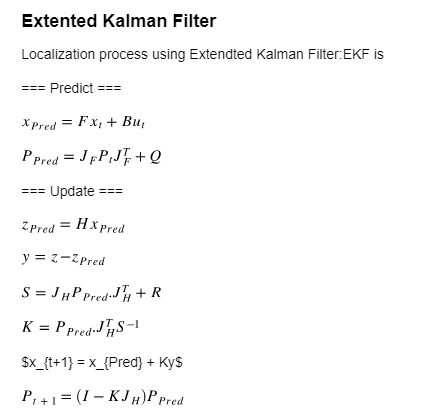

In [15]:
for i, curr_dat in enumerate(drive_data, 1):
    dt = curr_dat['t'] - prior_dat['t']
    u_t_control = np.array(
        [curr_dat['x_control'] - prior_dat['x_control'],
         curr_dat['y_control'] - prior_dat['y_control'],
         curr_dat['theta_control'] - prior_dat['theta_control']])
    
    u_t_sensor = np.array(
        [curr_dat['x_sensor'] - prior_dat['x_sensor'],
         curr_dat['y_sensor'] - prior_dat['y_sensor'],
         curr_dat['theta_sensor'] - prior_dat['theta_sensor']])
    
    r_control = curr_dat['nu_control'] / curr_dat['omega_control'] if curr_dat['omega_control'] > 10e-6 else 10e-6
    J_control = np.array([
        [1, 0, r_control * (-np.cos(x_true[2]) + np.cos(x_true[2] + dt * curr_dat['omega_control']))],
        [0, 1, r_control * (np.sin(x_true[2]) + np.sin(x_true[2] + dt * curr_dat['omega_control']))],
        [0, 0, 1]
    ])
    
    r_sensor = curr_dat['nu_sensor'] / curr_dat['omega_sensor'] if curr_dat['omega_sensor'] > 10e-6 else 10e-6
    J_sensor = np.array([
        [1, 0, r_sensor * (-np.cos(x_true[2]) + np.cos(x_true[2] + dt * curr_dat['omega_sensor'])) ],
        [0, 1, r_sensor * (np.sin(x_true[2]) + np.sin(x_true[2] + dt * curr_dat['omega_sensor']))],
        [0, 0, 1]
    ])
    
    # === Predict ===
    x_pred_control = x_true + u_t_control
    x_pred_sensor = x_true + u_t_sensor
    P_pred = J_control.dot(P).dot(J_control.T) + Q
    # === Update ===
    z_pred_control = H.dot(x_pred_control)
    z_pred_sensor = H.dot(x_pred_sensor)
    y = z_pred_sensor - z_pred_control
    S = J_sensor.dot(P_pred).dot(J_sensor.T) + R
    K = P_pred.dot(J_sensor.T).dot(np.linalg.inv(S))
    x_true = x_pred_control + K.dot(y)
    
    # Review
    print(
        f"x_true: {x_true}"
        # f"\nP {P}"
        f"\ny: {y}"
        f"\n"
    )
    # Setup for Next Iteration
    prior_dat = curr_dat
        

x_true: [ 5.13262838e-03 -1.40116290e-07 -5.45982623e-05]
y: [ 5.13262838e-03 -1.40116290e-07 -5.45982623e-05]

x_true: [ 1.01653849e+00 -1.85993017e-04 -3.12915718e-04]
y: [ 1.01140586e+00 -1.85852900e-04 -2.58317456e-04]

x_true: [2.37371319e+00 1.22712381e-03 7.15702803e-04]
y: [-5.94667893e+01 -5.54446117e+00 -2.14470739e-03]

x_true: [ 4.22852577e+00 -9.83139946e-04 -3.09897608e-03]
y: [ 1.85481258 -0.00221026 -0.00381468]

x_true: [ 5.95822383e+00 -7.02493497e-03 -3.88694860e-03]
y: [-7.22236220e+01 -6.98435054e+00 -3.96129844e-03]

x_true: [ 7.79760275 -0.02396098 -0.01452749]
y: [ 1.83937893 -0.01693604 -0.01064054]

x_true: [ 9.72119671e+00 -3.29669747e-03 -6.95526142e-03]
y: [ 1.92375043 -0.02066452  0.00757223]

x_true: [ 1.15403111e+01 -1.86910627e-02 -9.96945377e-03]
y: [-6.88258753e+01 -6.90776995e+00 -6.18751826e-03]

x_true: [ 1.36025619e+01  7.99959547e-03 -3.29644372e-03]
y: [-6.86830662e+01  5.75697728e+00  9.84633596e-03]

x_true: [ 1.49968856e+01  1.22676501e-02 -2


x_true: [-27.36400675  57.39745001   2.4940827 ]
y: [-4.68500984e+00  3.54406521e+00  2.37088798e-04]

x_true: [-32.20575494  61.05948262   2.49400334]
y: [-4.84174818e+00  3.66203261e+00 -7.93601211e-05]

x_true: [-37.09936994  64.76135006   2.49392527]
y: [-4.89361500e+00  3.70186743e+00 -7.80729408e-05]

x_true: [-42.17524845  68.60203415   2.49376779]
y: [-5.07587851e+00  3.84068409e+00 -1.57476695e-04]

x_true: [-47.51031544  64.56466683   2.49384819]
y: [-5.33539159e+00  4.03736907e+00  8.03996828e-05]

x_true: [-52.91811081  68.65783092   2.49353123]
y: [-5.40779537e+00  4.09316408e+00 -3.16964882e-04]



In [16]:
print(drive_data[-1])

{'y_sensor': 229.12670625978004, 'omega_control': 0.0, 'theta_control': 2.015061954575272, 'nu_control': 0.0, 'y_control': 873.6920579217742, 'x_control': 562.3550496119311, 'omega_sensor': -0.004363323129985824, 'nu_sensor': 93.3634415183401, 't': 1593807534.653601, 'x_sensor': -54.22435724569855, 'theta_sensor': 2.4935312256268163}
